# Marketing Promotion Campaign Uplift Modelling
### **Hijir Della Wirasti**

![](https://ambiata.com/images/blog/uplift-modeling_files/persuadables.png)

The goal of uplift modeling, also known as net lift or incremental response modeling, is to identify the “persuadables”, not waste efforts on “sure things” and “lost causes”, and avoid bothering “sleeping dogs”, or those who would react negatively to the treatment, if they exist. Uplift modeling has found application in many domains including marketing.

# Install and Load Packages

In [ ]:
!pip install -q causalml
!pip install -q scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.7 MB/s eta 0:00:00


In [ ]:
# import library

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

import scikitplot as skplt

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from causalml.inference.meta import BaseSClassifier
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
import causalml.metrics as metrics
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from IPython.display import Image

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 25
sns.set()

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [ ]:
raw_data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTha3RSltnpM2EhcdPSO6dBv-3o82ymLgpkcHC7IubuDeJYYWw52_VCF8XO_PZ9rRSI5HnSecoC3OQj/pub?output=csv")

In [ ]:
raw_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


# Data Profiling

In [ ]:
raw_data['offer'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

Check data structure

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


##  Statistical Summary

In [ ]:
# Mengecek distribusi data numerik:
raw_data.describe()


,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Mengecek distribusi data kategorikal:
raw_data.describe(include='object')


,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


In [ ]:
# Mengecek nilai unik untuk semua kolom dengan tipe data 'object' (kategorikal)
categorical_cols = raw_data.select_dtypes(include=['object']).columns

# Menampilkan nilai unik dari setiap kolom kategorikal
unique_values = {col: raw_data[col].unique() for col in categorical_cols}
unique_values

{'zip_code': array(['Surburban', 'Rural', 'Urban'], dtype=object),
 'channel': array(['Phone', 'Web', 'Multichannel'], dtype=object),
 'offer': array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)}

## Missing Values Analysis

In [ ]:
raw_data.isnull().sum()


,0
recency,0
history,0
used_discount,0
used_bogo,0
zip_code,0
is_referral,0
channel,0
offer,0
conversion,0


## Data Type Validation

In [ ]:
raw_data.dtypes


,0
recency,int64
history,float64
used_discount,int64
used_bogo,int64
zip_code,object
is_referral,int64
channel,object
offer,object
conversion,int64


### **Key Takeaways**
- **Tidak ada tipe data yang tampak salah**, semua kolom sesuai dengan konteks bisnisnya.  
- **Kolom numerik memiliki kombinasi integer dan float**, yang memudahkan analisis statistik dan pemodelan.  
- **Kolom kategorikal (`zip_code`, `channel`, `offer`) bisa diubah menjadi encoding jika akan digunakan dalam model machine learning.**  
- **Potensi Feature Engineering:**
  - **Menggabungkan `used_discount` & `used_bogo`** ke dalam satu kolom seperti `promotion_usage = used_discount + used_bogo`.
  - **Mengonversi `zip_code` ke encoding numerik** jika akan dipakai dalam pemodelan.

## Outlier Detection

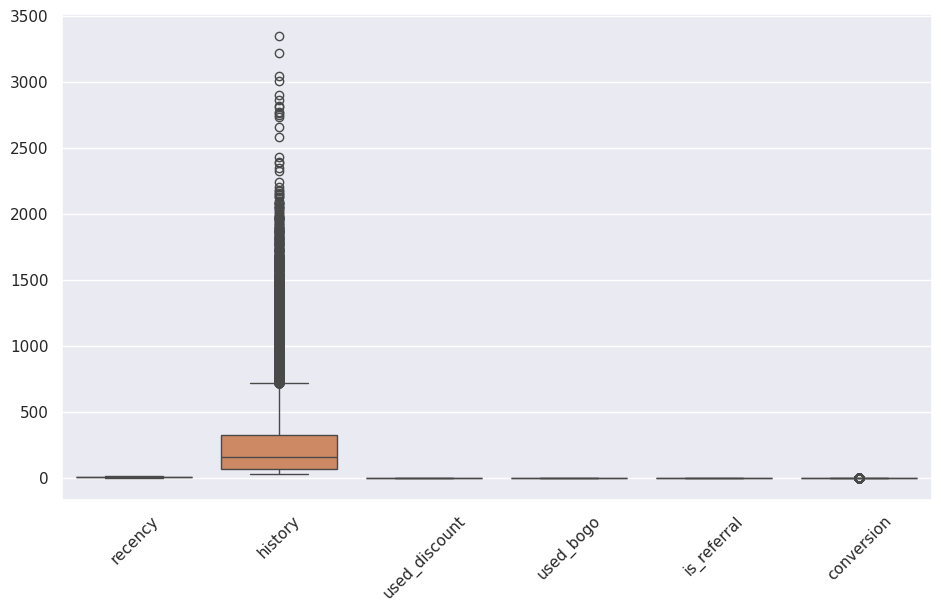

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=raw_data.select_dtypes(include=np.number))
plt.xticks(rotation=45)
plt.show()


## Feature Relationships

In [ ]:
raw_data.corr(numeric_only=True)

,recency,history,used_discount,used_bogo,is_referral,conversion
recency,1.000000,-0.246591,-0.031336,-0.026617,-0.052106,-0.074765
history,-0.246591,1.000000,0.112677,0.114685,0.223279,0.065153
used_discount,-0.031336,0.112677,1.000000,-0.816943,0.020900,0.006712
used_bogo,-0.026617,0.114685,-0.816943,1.000000,0.021346,0.051999
is_referral,-0.052106,0.223279,0.020900,0.021346,1.000000,-0.073924
conversion,-0.074765,0.065153,0.006712,0.051999,-0.073924,1.000000


## Target Variable Distribution

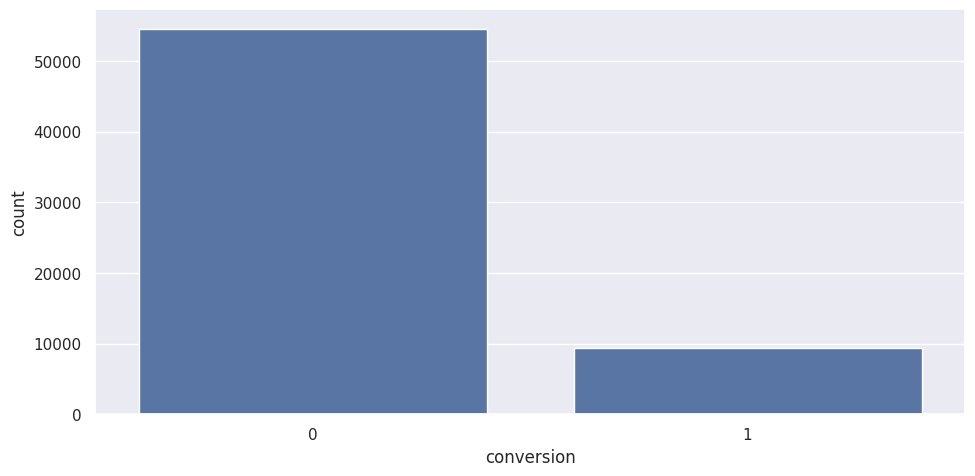

In [ ]:
# Mengecek distribusi target (conversion):
sns.countplot(x='conversion', data=raw_data)
plt.show()

In [ ]:
raw_data['conversion'].value_counts(normalize=True)


,proportion
conversion,
0,0.853219
1,0.146781


# EDA

In [ ]:
# Setting style untuk visualisasi
sns.set(style="whitegrid")

## Univariate Analysis

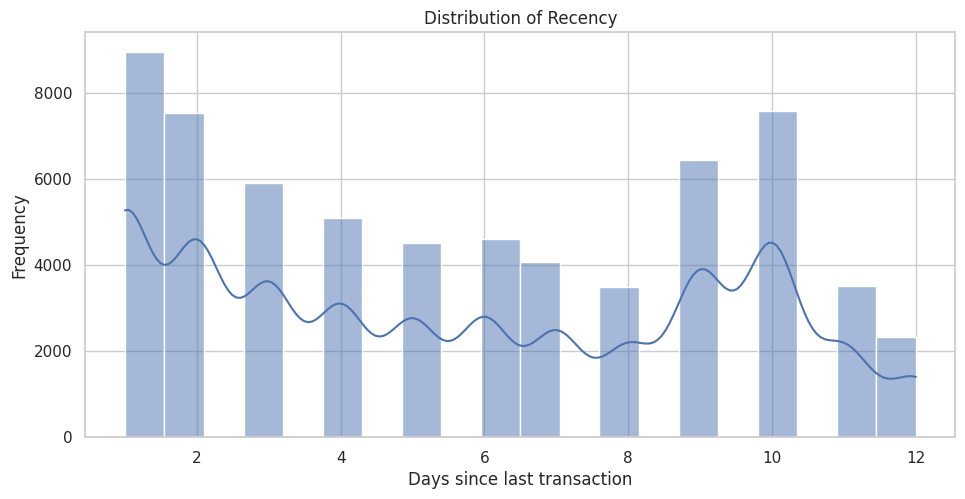

In [ ]:
# 1. Distribusi Recency (Seberapa lama sejak transaksi terakhir)
plt.figure(figsize=(10, 5))
sns.histplot(raw_data['recency'], bins=20, kde=True)
plt.title("Distribution of Recency")
plt.xlabel("Days since last transaction")
plt.ylabel("Frequency")
plt.show()

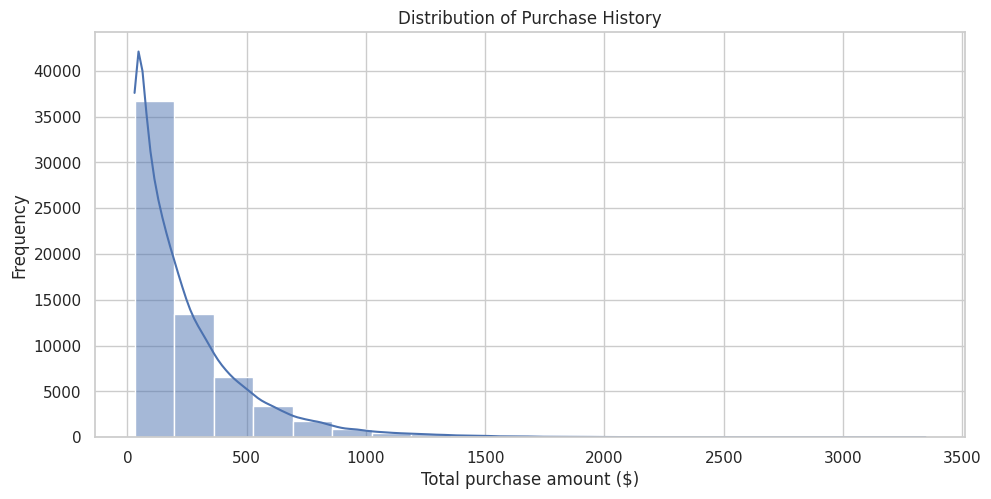

In [ ]:
# 2. Distribusi History (Total Pembelian Sebelumnya)
plt.figure(figsize=(10, 5))
sns.histplot(raw_data['history'], bins=20, kde=True)
plt.title("Distribution of Purchase History")
plt.xlabel("Total purchase amount ($)")
plt.ylabel("Frequency")
plt.show()

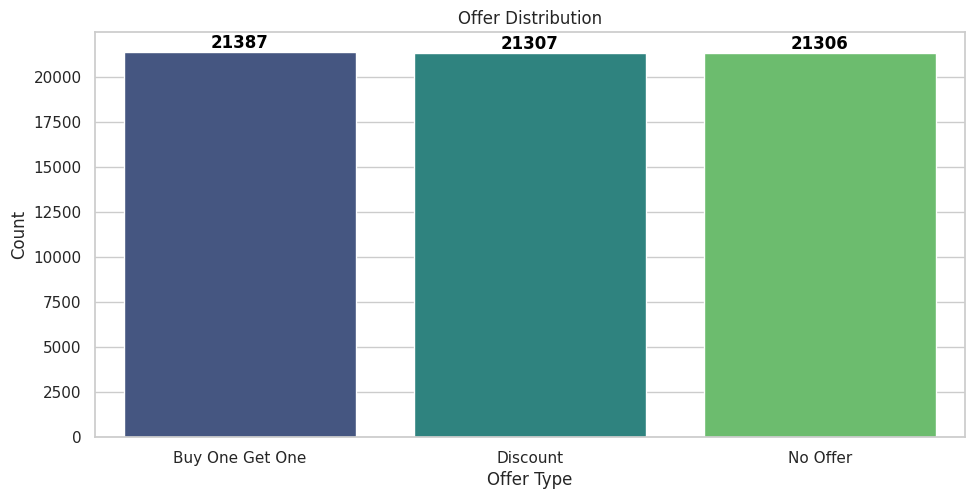

In [ ]:
# 3. Countplot untuk Offer (Promosi yang diterima pelanggan
offer_counts = raw_data['offer'].value_counts()

# Membuat countplot dengan data label
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="offer", data=raw_data, order=offer_counts.index, palette="viridis")

# Menambahkan label di atas setiap batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.title("Offer Distribution")
plt.xlabel("Offer Type")
plt.ylabel("Count")
plt.show()

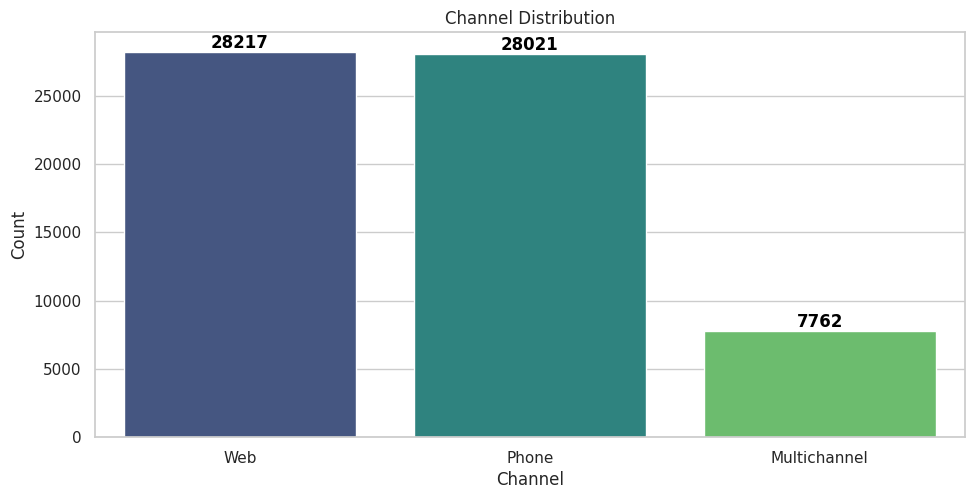

In [ ]:
# 4. Countplot untuk Channel (Platform yang digunakan pelanggan)
channel_counts = raw_data['channel'].value_counts()

# Membuat countplot dengan data label
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="channel", data=raw_data, order=channel_counts.index, palette="viridis")

# Menambahkan label di atas setiap batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.title("Channel Distribution")
plt.xlabel("Channel")
plt.ylabel("Count")
plt.show()


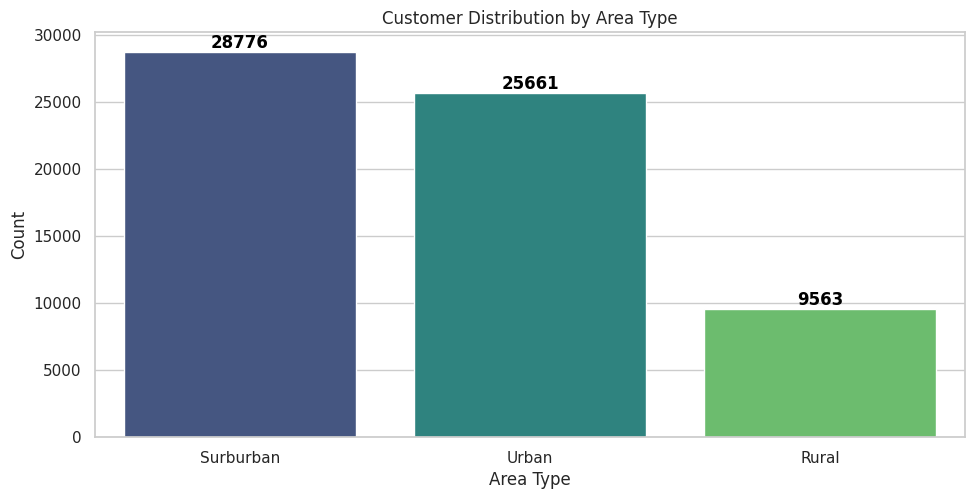

In [ ]:
# 5. Countplot Area Type (Distribusi Wilayah Pelanggan)

# Menghitung jumlah setiap kategori dalam kolom "zip_code"
area_counts = raw_data['zip_code'].value_counts()

# Membuat countplot dengan data label
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="zip_code", data=raw_data, order=area_counts.index, palette="viridis")

# Menambahkan label di atas setiap batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Menampilkan angka jumlah pelanggan
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.title("Customer Distribution by Area Type")
plt.xlabel("Area Type")
plt.ylabel("Count")
plt.show()

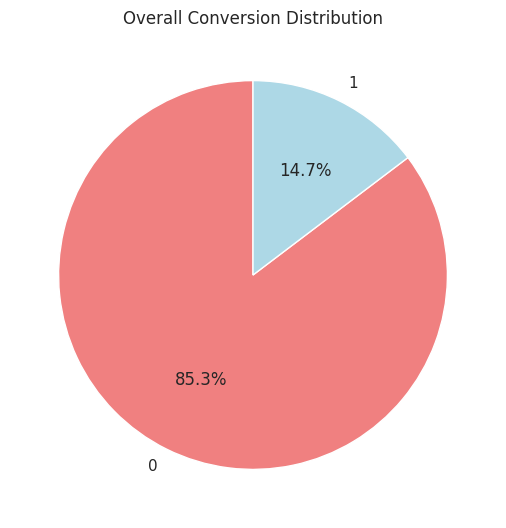

In [ ]:
# 6. Pie Chart Distribusi Conversion (Berapa banyak pelanggan yang berhasil dikonversi)
plt.figure(figsize=(6, 6))
raw_data['conversion'].value_counts().plot.pie(autopct="%1.1f%%", colors=["lightcoral", "lightblue"], startangle=90)
plt.title("Overall Conversion Distribution")
plt.ylabel("")
plt.show()

## Bivariate Analysis

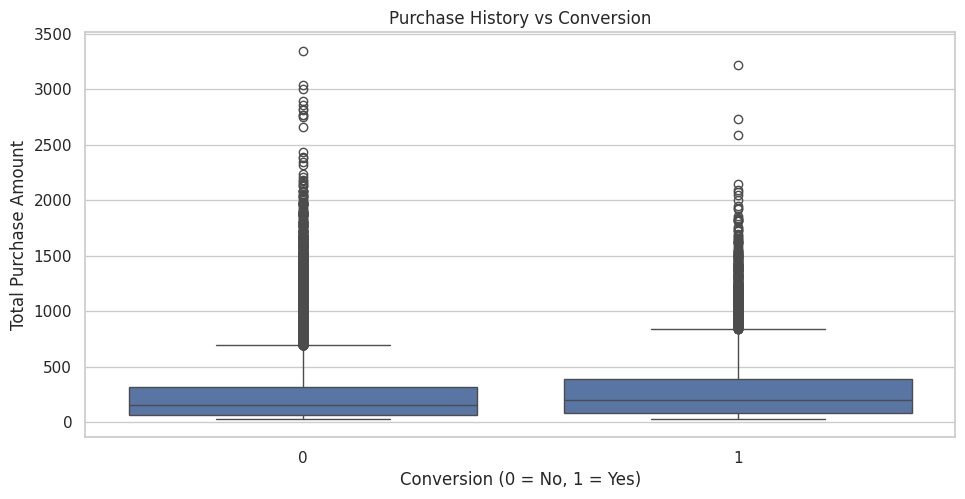

In [ ]:
# 7. Boxplot History vs Conversion (Melihat pola pelanggan yang berhasil dikonversi)
plt.figure(figsize=(10, 5))
sns.boxplot(x="conversion", y="history", data=raw_data)
plt.title("Purchase History vs Conversion")
plt.xlabel("Conversion (0 = No, 1 = Yes)")
plt.ylabel("Total Purchase Amount")
plt.show()

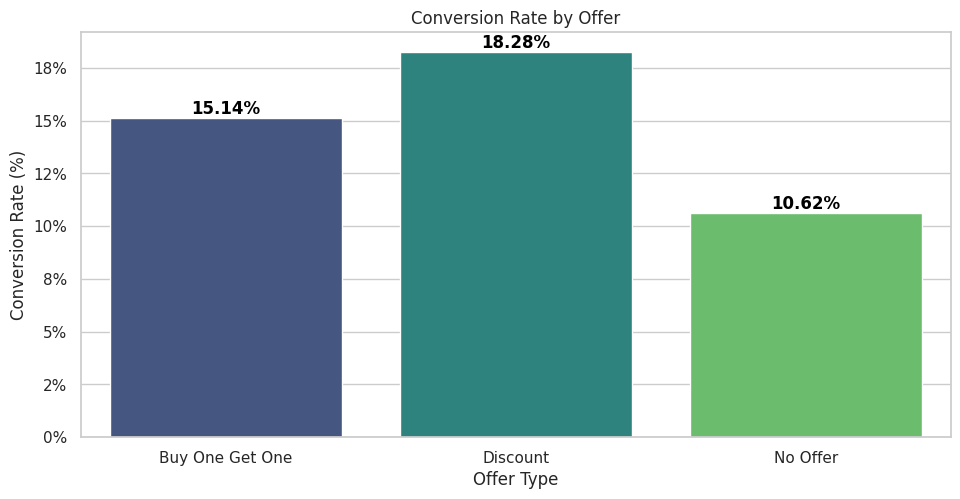

In [ ]:
# 8. Conversion Rate berdasarkan Offer
# Menghitung conversion rate berdasarkan offer
conversion_rates = raw_data.groupby("offer")["conversion"].mean()

# Membuat barplot dengan data label
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette="viridis")

# Menambahkan label di atas setiap batang dalam format persen (dengan 2 desimal)
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.2f}%',  # Konversi ke persen dengan 2 desimal
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Mengubah sumbu Y agar dalam format persen
ax.set_yticklabels([f'{x*100:.0f}%' for x in ax.get_yticks()])

plt.title("Conversion Rate by Offer")
plt.xlabel("Offer Type")
plt.ylabel("Conversion Rate (%)")
plt.show()


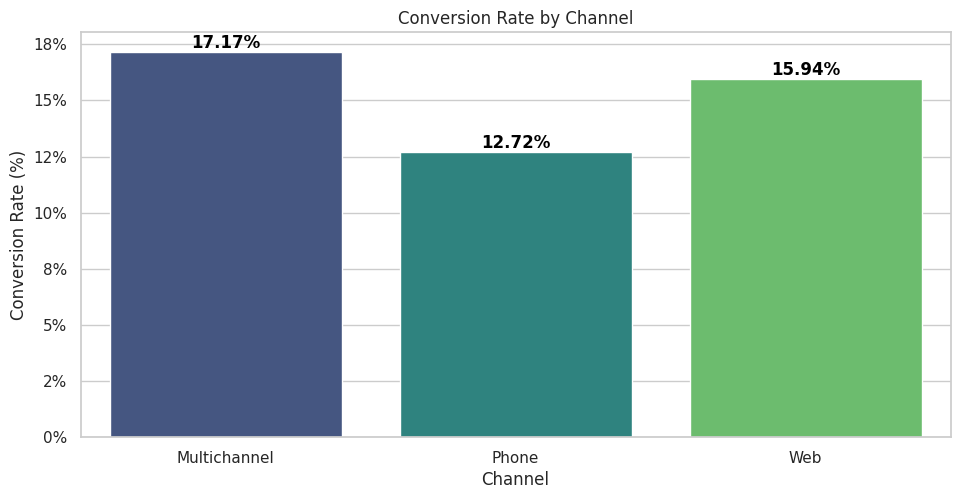

In [ ]:
# 9. Conversion Rate berdasarkan Channel
# Menghitung conversion rate berdasarkan channel
conversion_rates_channel = raw_data.groupby("channel")["conversion"].mean()

# Membuat barplot dengan data label
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=conversion_rates_channel.index, y=conversion_rates_channel.values, palette="viridis")

# Menambahkan label di atas setiap batang dalam format persen (dengan 2 desimal)
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.2f}%',  # Konversi ke persen dengan 2 desimal
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Mengubah sumbu Y agar dalam format persen
ax.set_yticklabels([f'{x*100:.0f}%' for x in ax.get_yticks()])

plt.title("Conversion Rate by Channel")
plt.xlabel("Channel")
plt.ylabel("Conversion Rate (%)")  # Menyesuaikan label sumbu Y
plt.show()

## Multivariate Analysis

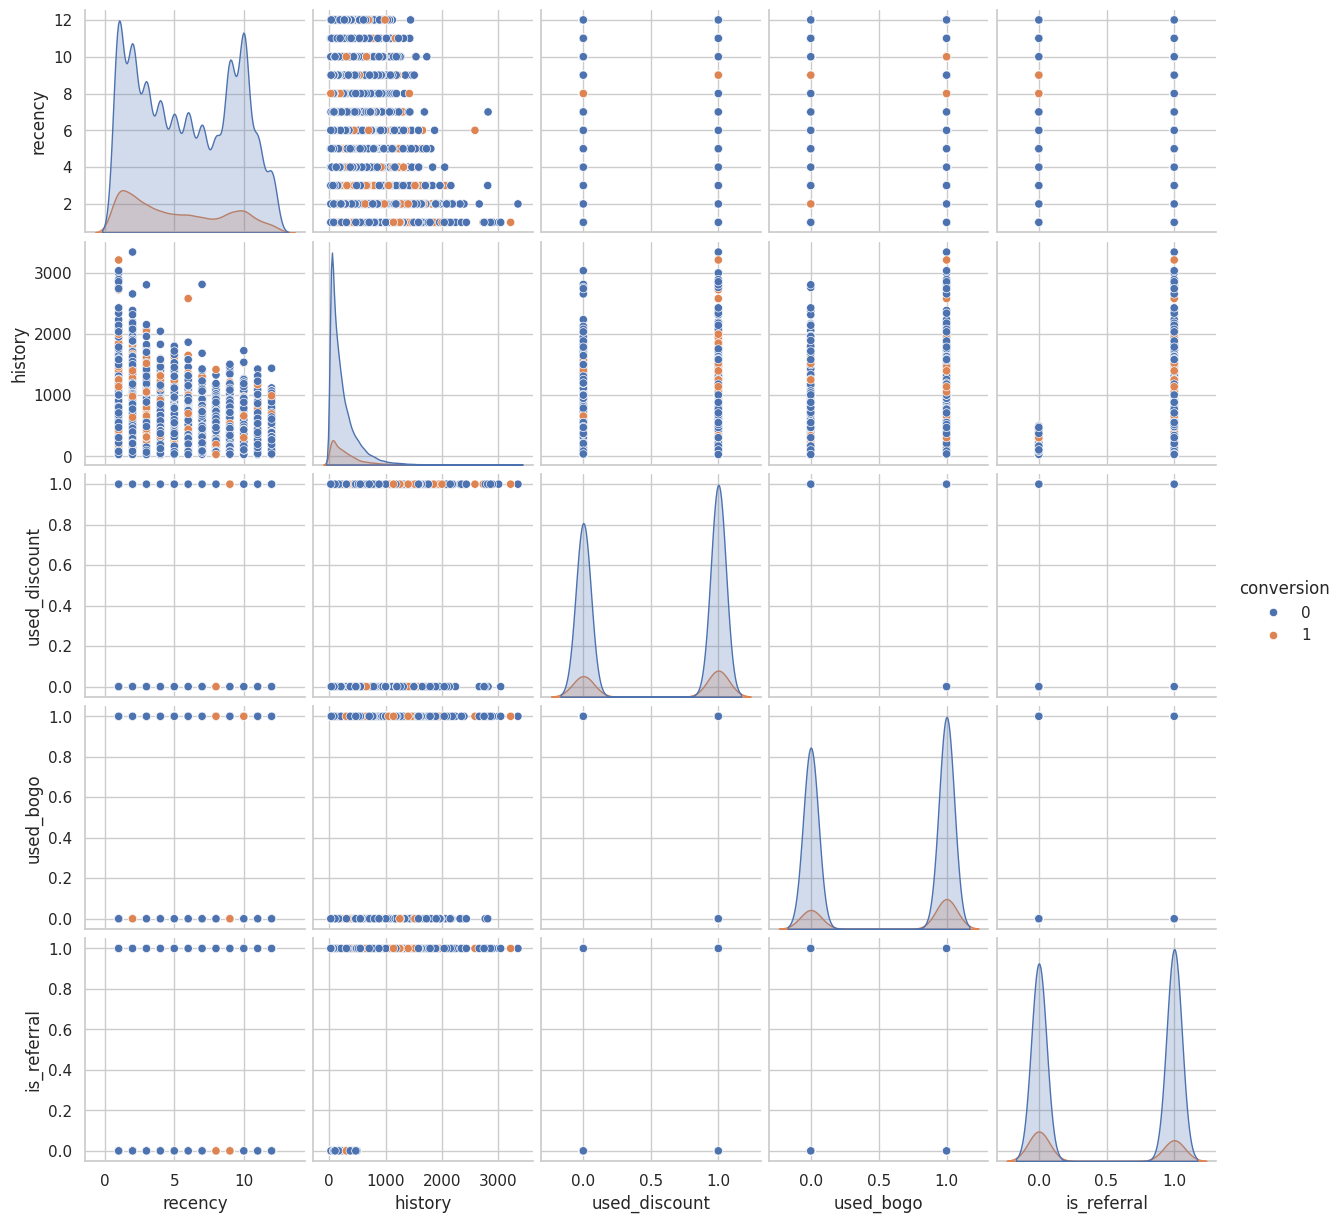

In [ ]:
# 10. Pairplot untuk melihat pola hubungan antar variabel numerik:
sns.pairplot(raw_data, hue='conversion')
plt.show()

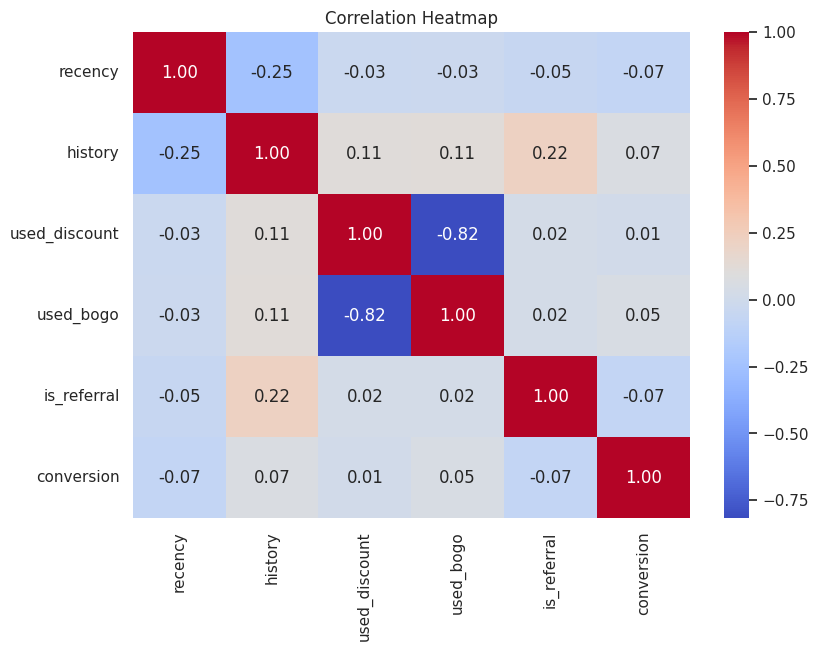

In [ ]:
# 11. Heatmap Korelasi antar Variabel Numerik
plt.figure(figsize=(8, 6))
sns.heatmap(raw_data.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Parameter

In [ ]:
# Definisi variabel untuk uplift modeling
treatment_var = 'offer'      # Treatment variable
target_var = 'conversion'    # Target variable (tidak di-drop!)

# Definisi control, treatment, dan exclusion group
control_cat = 'No Offer'     # Grup kontrol (tidak mendapat diskon)
treatment_cat = 'Discount'   # Grup yang mendapat diskon (fokus uplift)
exclusion_cat = 'Buy One Get One'  # Treatment yang diabaikan

# Variabel yang tidak diperlukan dalam model
var_to_drop = ['used_discount', 'used_bogo']  # Menghapus variabel redundant

# Variabel kategorikal yang perlu encoding
cat_cols = ['zip_code', 'channel']

In [ ]:
# menghapus kategori yang tidak diperlukan

if exclusion_cat != None:
  raw_data = raw_data.loc[raw_data[treatment_var] != exclusion_cat].reset_index(drop=True)

In [ ]:
raw_data['offer'].unique()

array(['No Offer', 'Discount'], dtype=object)

In [ ]:
raw_data.drop(columns=var_to_drop, inplace=True)

In [ ]:
raw_data.head()

,recency,history,zip_code,is_referral,channel,offer,conversion
0,6,329.08,Rural,1,Web,No Offer,0
1,9,675.83,Rural,1,Web,Discount,0
2,9,675.07,Rural,1,Phone,Discount,0
3,2,101.64,Urban,0,Web,Discount,1
4,4,241.42,Rural,1,Multichannel,No Offer,0


In [ ]:
# split train dan test

X_train, X_test = train_test_split(
    raw_data,
    test_size = 0.5,
    random_state = 1000
)

In [ ]:
X_train

,recency,history,zip_code,is_referral,channel,offer,conversion
25807,3,383.94,Rural,0,Web,No Offer,0
35060,1,263.16,Urban,1,Web,No Offer,0
42391,6,194.72,Urban,0,Phone,Discount,0
6352,11,66.96,Surburban,1,Web,No Offer,0
18376,5,640.16,Urban,1,Multichannel,Discount,0
...,...,...,...,...,...,...,...
18782,9,162.98,Surburban,0,Phone,Discount,0
3776,7,191.86,Urban,0,Phone,Discount,0
6215,7,156.75,Surburban,0,Web,No Offer,0
4695,4,39.00,Rural,1,Web,No Offer,0


In [ ]:
X_test

,recency,history,zip_code,is_referral,channel,offer,conversion
2930,6,353.32,Surburban,0,Multichannel,No Offer,0
7931,10,60.06,Urban,1,Web,No Offer,0
26143,12,151.73,Rural,0,Web,Discount,0
33666,9,29.99,Rural,0,Phone,Discount,0
13268,5,672.56,Urban,1,Phone,No Offer,1
...,...,...,...,...,...,...,...
22530,7,150.66,Surburban,0,Phone,Discount,0
15777,1,29.99,Surburban,0,Web,Discount,0
11304,9,51.58,Surburban,0,Web,No Offer,0
30656,7,56.26,Urban,1,Phone,No Offer,0


In [ ]:
X_train['offer'].value_counts()

,count
offer,
No Offer,10654
Discount,10652


In [ ]:
X_test['offer'].value_counts()

,count
offer,
Discount,10655
No Offer,10652


In [ ]:
# Encode categorical variables on X train data
dummies = pd.get_dummies(X_train[cat_cols], drop_first=True)
X_train = pd.concat([X_train.drop(cat_cols, axis=1), dummies], axis=1)

# Encode categorical variables on X test data
dummies = pd.get_dummies(X_test[cat_cols], drop_first=True)
X_test = pd.concat([X_test.drop(cat_cols, axis=1), dummies], axis=1)

In [ ]:
X_train.head()

,recency,history,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
25807,3,383.94,0,No Offer,0,False,False,False,True
35060,1,263.16,1,No Offer,0,False,True,False,True
42391,6,194.72,0,Discount,0,False,True,True,False
6352,11,66.96,1,No Offer,0,True,False,False,True
18376,5,640.16,1,Discount,0,False,True,False,False


In [ ]:
is_treat = X_train[X_train.offer != control_cat]
not_treat = X_train[X_train.offer == control_cat]

In [ ]:
# berisi orang yang mendapatkan discount (treatment)
is_treat.head()

,recency,history,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
42391,6,194.72,0,Discount,0,False,True,True,False
18376,5,640.16,1,Discount,0,False,True,False,False
10945,1,58.07,1,Discount,0,False,True,False,True
27203,1,262.07,1,Discount,0,True,False,False,True
14405,6,91.25,1,Discount,0,False,True,False,True


In [ ]:
not_treat.head()

,recency,history,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
25807,3,383.94,0,No Offer,0,False,False,False,True
35060,1,263.16,1,No Offer,0,False,True,False,True
6352,11,66.96,1,No Offer,0,True,False,False,True
19446,11,151.21,1,No Offer,0,False,False,True,False
14285,7,434.17,0,No Offer,0,True,False,False,True


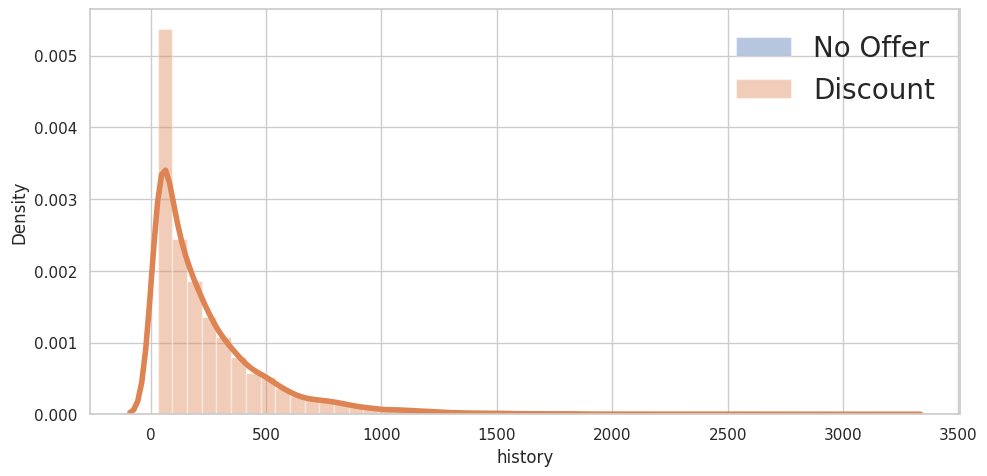

In [ ]:
# bins = 25
sns.distplot(is_treat[is_treat['offer']==control_cat].history, hist=True, kde=True, kde_kws={'linewidth': 4}, label='No Offer')
sns.distplot(is_treat[is_treat['offer']==treatment_cat].history, hist=True, kde=True, kde_kws={'linewidth': 4}, label='Discount')
# sns.distplot(not_treat.history, hist=True, kde=True, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

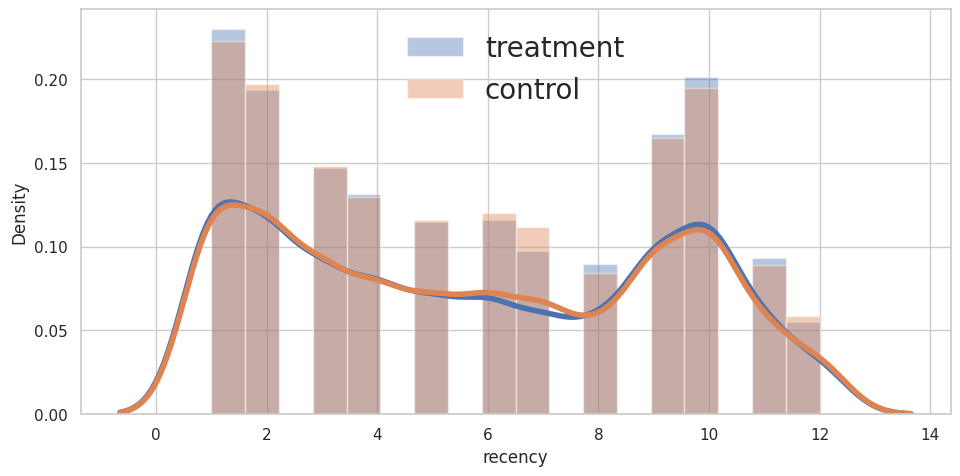

In [ ]:
# bins = 25
sns.distplot(is_treat.recency, hist=True, kde=True, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.recency, hist=True, kde=True, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

# Modeling

In [ ]:
X_train.head()

,recency,history,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
25807,3,383.94,0,No Offer,0,False,False,False,True
35060,1,263.16,1,No Offer,0,False,True,False,True
42391,6,194.72,0,Discount,0,False,True,True,False
6352,11,66.96,1,No Offer,0,True,False,False,True
18376,5,640.16,1,Discount,0,False,True,False,False


In [ ]:
x_col = X_train.drop([treatment_var, target_var], axis = 1).columns.tolist()

x_col

['recency',
 'history',
 'is_referral',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Phone',
 'channel_Web']

# S Learner

In [ ]:
slearner = BaseSClassifier(LGBMClassifier(), control_name=control_cat)

In [ ]:
# menghitung ATE = Average Treatment Effect -> berapa rata rata peningkatan jika dilakukan treatment

# ATE diaplikasikan ke data training

slearner.estimate_ate(X_train[x_col].values, X_train[treatment_var].values, X_train[target_var].values, bootstrap_ci  = True)

[LightGBM] [Info] Number of positive: 3064, number of negative: 18242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 21306, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143809 -> initscore=-1.784005
[LightGBM] [Info] Start training from score -1.784005


array([0.07472693])

In [ ]:
# CATE - Conditional Average Treatment Effect

# diaplikasikan ke data testing

slearner_tau = slearner.predict(X_test[x_col].values, X_test[treatment_var].values, X_test[target_var].values)

In [ ]:
# uplift tiap individu

slearner_tau

array([[0.06875434],
       [0.04428244],
       [0.04212463],
       ...,
       [0.06602978],
       [0.06871734],
       [0.08325982]])

In [ ]:
len(slearner_tau)

21307

In [ ]:
len(X_test)

21307

In [ ]:
slearner_tau.min()

-0.21795091438296182

In [ ]:
slearner_tau.max()

0.4027478482150437

In [ ]:
X_test['s_learner_tau'] = slearner_tau

In [ ]:
X_test.head()

,recency,history,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,s_learner_tau
2930,6,353.32,0,No Offer,0,True,False,False,False,0.068754
7931,10,60.06,1,No Offer,0,False,True,False,True,0.044282
26143,12,151.73,0,Discount,0,False,False,False,True,0.042125
33666,9,29.99,0,Discount,0,False,False,True,False,0.076798
13268,5,672.56,1,No Offer,1,False,True,True,False,0.143043


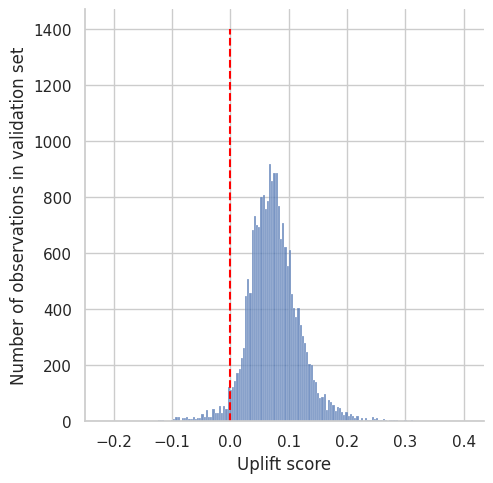

In [ ]:
sns.displot(data = X_test['s_learner_tau'])
plt.vlines([0], 0, 1400, linestyles = "dashed", colors = "red")
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set');

# Uplift Tree

In [ ]:
uplift_model = UpliftRandomForestClassifier(control_name=control_cat, random_state=1000)

In [ ]:
uplift_model.fit(
    X_train[x_col].values,
    treatment = X_train[treatment_var].values,
    y = X_train[target_var].values
)

In [ ]:
y_pred = uplift_model.predict(X_test[x_col].values, full_output=True)

In [ ]:
y_pred.head()

,No Offer,Discount,recommended_treatment,delta_Discount,max_delta
0,0.136495,0.205792,1,0.069298,0.069298
1,0.046539,0.117731,1,0.071192,0.071192
2,0.128670,0.199293,1,0.070622,0.070622
3,0.107676,0.170546,1,0.062870,0.062870
4,0.110455,0.197425,1,0.086970,0.086970


In [ ]:
y_pred[y_pred['recommended_treatment']==0]

,No Offer,Discount,recommended_treatment,delta_Discount,max_delta
17537,0.200192,0.197303,0,-0.002889,-0.002889


In [ ]:
X_test['uplift_forest_tau'] = uplift_model.predict(X_test[x_col].values, full_output=False)

In [ ]:
X_test.head()

,recency,history,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,s_learner_tau,uplift_forest_tau
2930,6,353.32,0,No Offer,0,True,False,False,False,0.068754,0.069298
7931,10,60.06,1,No Offer,0,False,True,False,True,0.044282,0.071192
26143,12,151.73,0,Discount,0,False,False,False,True,0.042125,0.070622
33666,9,29.99,0,Discount,0,False,False,True,False,0.076798,0.062870
13268,5,672.56,1,No Offer,1,False,True,True,False,0.143043,0.086970


# Melihat Dampak Dari Treatment

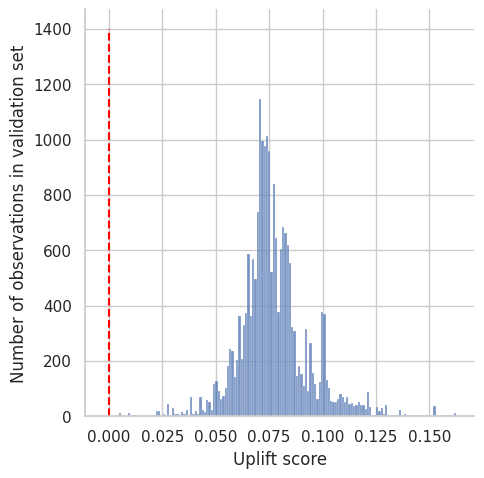

In [ ]:
sns.displot(data = X_test['uplift_forest_tau'])
plt.vlines([0], 0, 1400, linestyles = "dashed", colors = "red")
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set');

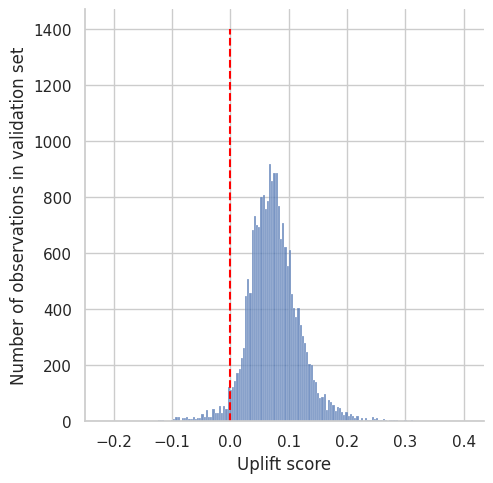

In [ ]:
sns.displot(data = X_test['s_learner_tau'])
plt.vlines([0], 0, 1400, linestyles = "dashed", colors = "red")
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set');

# Evaluasi Model

In [ ]:
def auuc_metric_maker(dataframe, tau_outcome_var, control_category, treatment_category):

  treatment_category_result = X_test[[tau_outcome_var]].reset_index(drop=True)
  treatment_category_result.columns = [treatment_category]

  # If all deltas are negative, assing to control; otherwise assign to the treatment
  # with the highest delta
  best_treatment = np.where(
      (treatment_category_result < 0).all(axis=1),
      control_category,
      treatment_category_result.idxmax(axis=1)
  )
  # Create indicator variables for whether a unit happened to have the
  # recommended treatment or was in the control group
  actual_is_best = np.where(dataframe[treatment_var] == best_treatment, 1, 0)
  actual_is_control = np.where(dataframe[treatment_var] == control_category, 1, 0)

  synthetic = (actual_is_best == 1) | (actual_is_control == 1)
  synth = treatment_category_result[synthetic]

  auuc_score = (synth.assign(
      is_treated = 1 - actual_is_control[synthetic],
      conversion = dataframe.loc[synthetic, target_var].values,
      model_result = synth.max(axis=1)
  ).drop(columns=list([treatment_category]))).rename(columns = {"model_result": tau_outcome_var})

  return auuc_score

## Evaluasi S Learner

In [ ]:
slearner_auuc_score = auuc_metric_maker(X_test, tau_outcome_var = "s_learner_tau", control_category = control_cat, treatment_category = treatment_cat)

In [ ]:
slearner_auuc_score.head()

,is_treated,conversion,s_learner_tau
0,0,0,0.068754
1,0,0,0.044282
2,1,0,0.042125
3,1,0,0.076798
4,0,1,0.143043


In [ ]:
slearner_auuc_score.min()

,0
is_treated,0.000000
conversion,0.000000
s_learner_tau,-0.198319


In [ ]:
# Berapa jumlah conversion yang bisa diharapkan

slearner_auuc_score.groupby('is_treated').sum()[[target_var]]

,conversion
is_treated,
0,1144
1,1877


# Evaluasi Forest

In [ ]:
uplift_forest_auuc_score = auuc_metric_maker(X_test, tau_outcome_var = "uplift_forest_tau", control_category = control_cat, treatment_category = treatment_cat)

In [ ]:
uplift_forest_auuc_score.head()

,is_treated,conversion,uplift_forest_tau
0,0,0,0.069298
1,0,0,0.071192
2,1,0,0.070622
3,1,0,0.062870
4,0,1,0.086970


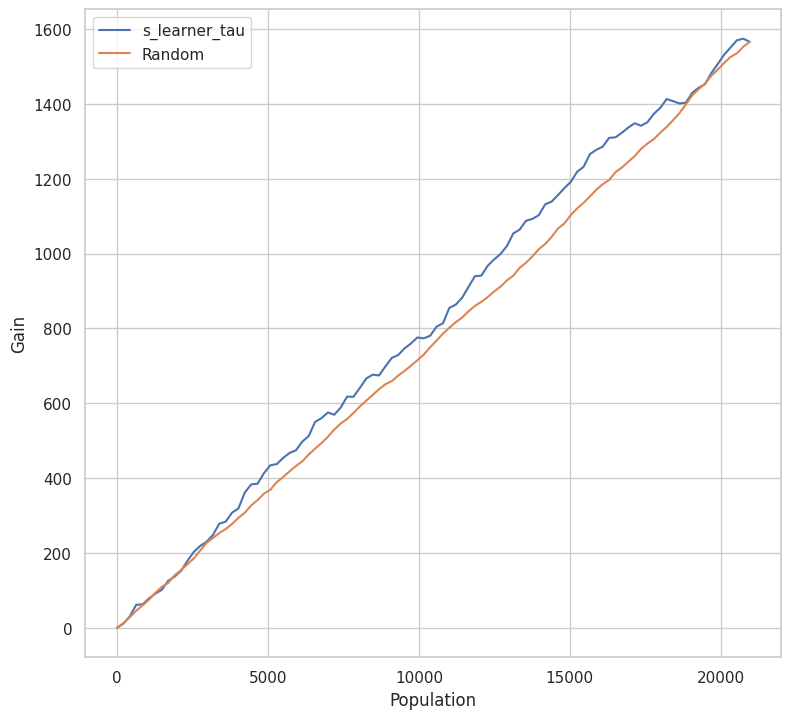

In [ ]:
metrics.plot_gain(slearner_auuc_score, outcome_col=target_var, treatment_col='is_treated')

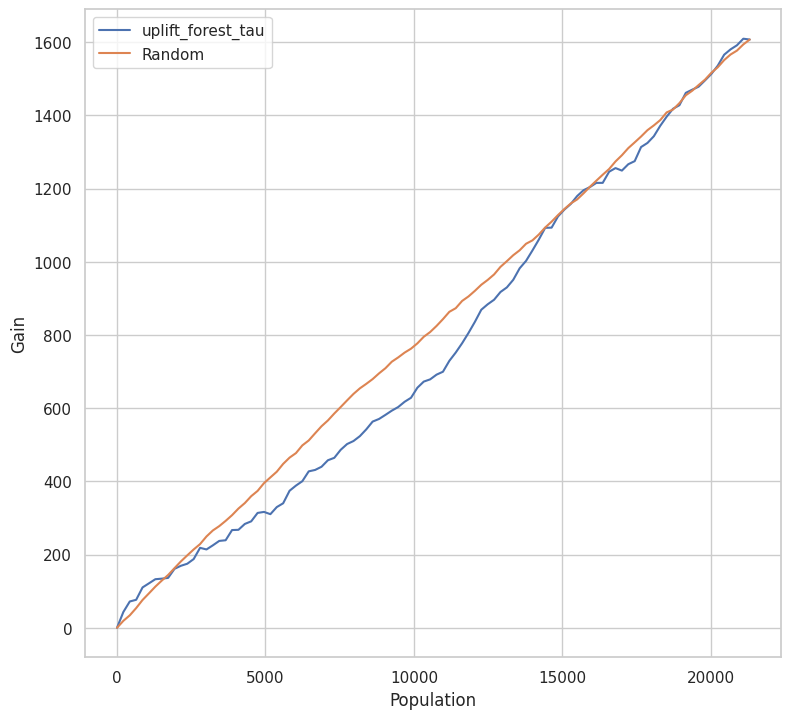

In [ ]:
metrics.plot_gain(uplift_forest_auuc_score, outcome_col=target_var, treatment_col='is_treated')

# Metrics

In [ ]:
# auc slearner
metrics.auuc_score(slearner_auuc_score, outcome_col=target_var, treatment_col='is_treated')

,0
s_learner_tau,0.523574
Random,0.490822


In [ ]:
# auc forest
metrics.auuc_score(uplift_forest_auuc_score, outcome_col=target_var, treatment_col='is_treated')

,0
uplift_forest_tau,0.476887
Random,0.509135


# Quantile Metrics

In [ ]:
def quantile_and_treatment(dataframe, tau_outcome_var, treatment_variable, control_category, treatment_category):
  # Bin uplift score by using quantile
  score_quantiles, score_quantile_bins = pd.qcut(
    x = dataframe[tau_outcome_var],
    q = 10,
    retbins = True,
    duplicates = 'drop'
  )
  dataframe['Quantile bin'] = score_quantiles
  # Calculate number of samples for each bins
  count_by_quantile_and_treatment = dataframe.groupby(['Quantile bin', treatment_variable])[treatment_variable].count().unstack(-1)
  return count_by_quantile_and_treatment[[control_category, treatment_category]]

In [ ]:
final_result = quantile_and_treatment(X_test, tau_outcome_var = "uplift_forest_tau", treatment_variable = treatment_var, control_category = control_cat, treatment_category = treatment_cat)

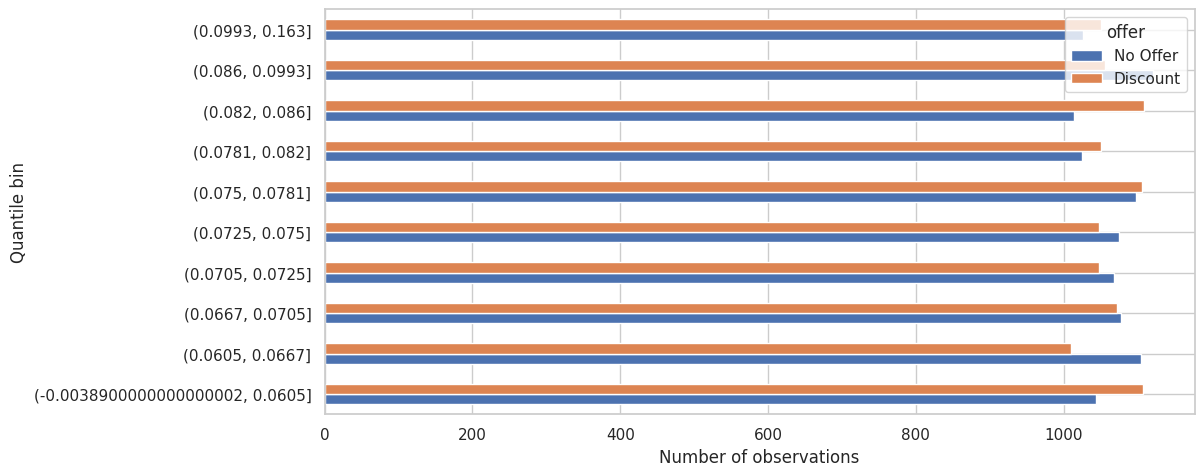

In [ ]:
final_result.plot.barh()
plt.xlabel('Number of observations');

# Feature Importance (Kolom/Var yang paling berpengaruh terhadap uplfit)

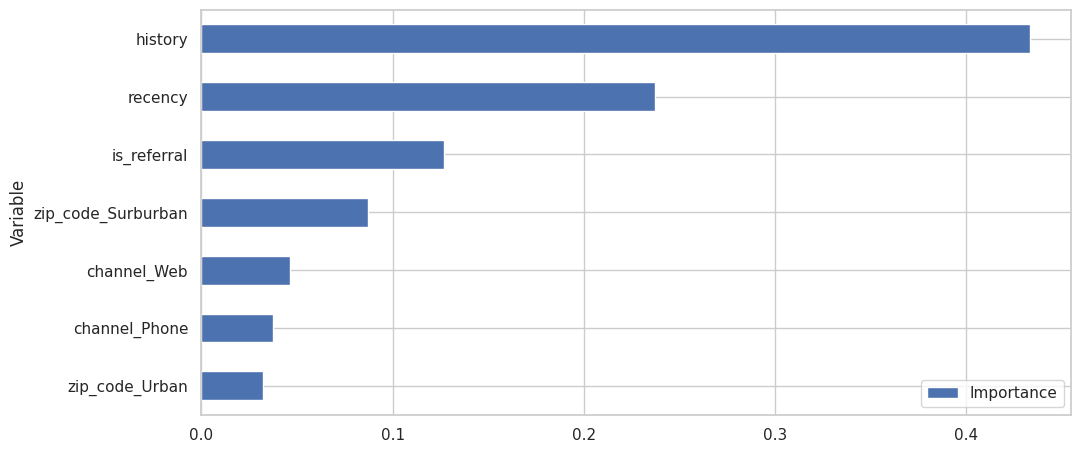

In [ ]:
pd.DataFrame(
    {
        "Variable": x_col,
        "Importance": uplift_model.feature_importances_
    }
).sort_values(by="Importance", ascending = True).plot(x = 'Variable', y = 'Importance', kind = 'barh');